# 주제: CNN을 이용한 Image Classification 구현하고 성능 개선하기

## 실습 가이드
    1. 데이터를 다운로드하여 Colab에 불러옵니다.
    2. 필요한 라이브러리는 import 가능합니다.
    3. 코드는 위에서부터 아래로 순서대로 실행합니다.

## 데이터 소개
    - 이번 주제는 Intel image classification dataset을 사용합니다.
    - Intel image classification dataset은 buildings, forest, mountains, glacier, sea, street 6개의 class로 구성되어 있습니다.
    - 파일은 하나의 압축파일로 구성되며 압축파일은 다음과 같이 구성되어 있습니다.
    - 모든 데이터는 각 class 이름에 해당되는 directory 아래에 있습니다.    

    1. seg_train
      - training용 data
      
    2. seg_test
      - test/validation용 data
      - label 있음
      - 이번 실습에서는 validation data로 사용

    3. set_pred
      - test용 data
      - label 없음
      - 이번 실습에서는 사용하지 않음

- 원본 데이터 출처: https://www.kaggle.com/puneet6060/intel-image-classification

## 문제 소개
    - 이번 실습에서는 image classification model을 만들어서 학습하고, 성능을 향상하기 위한 방법들을 찾아서 학습해보도록 하겠습니다.

## 최종 목표    
    - pre-trained CNN 활용 방법 이해
    - CNN의 성능을 올리기 위한 다양한 방법 습득

- 출제자: 이진원 강사

## Step 1. 데이터 다운로드 및 전처리

In [43]:
## library를 import 합니다
## 추가로 필요한 library가 있으면 추가로 import 해도 좋습니다
import os
import numpy as np
import random
from datetime import datetime
import time
import math
# import gdown
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Softmax

AUTOTUNE = tf.data.AUTOTUNE
# 데이터를 읽어오는 데 필요한 스레드의 개수를 TensorFlow가 자동으로 관리

# AUTOTUNE을 사용하는 주된 이유는 데이터 입력 파이프라인의 성능을 최적화하기 위해서입니다. 
# 이를 통해 데이터를 배치로 모으거나, 데이터를 변형(preprocessing)할 때 필요한 CPU 자원을 TensorFlow가 실행 시간에 결정하게 되어, 
# 개발자가 수동으로 병렬 처리에 필요한 자원을 설정하는 것보다 효율적으로 리소스를 관리할 수 있게 합니다.

# 이 변수를 설정한 후에는, TensorFlow의 Dataset 객체의 메소드인 .prefetch(), .map() 등에 인자로 전달하여 사용할 수 있습니다. 
# 예를 들어, dataset.prefetch(AUTOTUNE)은 데이터셋이 학습하는 동안 다음 데이터 배치를 미리 준비하도록 TensorFlow에 지시하며, 
# 이 과정에서 AUTOTUNE을 사용해 I/O 병목 현상을 줄이고, 학습 속도를 향상시킬 수 있습니다.


In [3]:
## Hyper-Parameter 설정
# image resolution
RES = 224
# class 수 
N_CLASS = 6
# batch size
N_BATCH = 64
# epoch 수
N_EPOCH = 50
# learning rate
LR = 0.0001

### 문제 1. 데이터 불러오기

    - data는 아래 url(google drive)에 저장되어 있습니다.(tar 파일)
    - gdown library를 이용하여 data를 다운받고, 현재 directory에 tar파일 압축을 풀어줍니다.
    

In [ ]:
data_url = 'https://drive.google.com/uc?id=1bDyPlWP3AczXJbBmmjSGuAJXY7R_IjeJ'

In [4]:
## data download 받기(gdown.download 사용)
##### CODE HERE #####
# gdown.download('url', 'file_name', quiet = False)

!tar -xf ./datasets/intel_image_classification.tar

    - 아래와 같이 train dataset은 train_dir, validation dataset은 val_dir로 경로를 설정합니다

In [4]:
data_dir = "./datasets/ch01/"
train_dir = os.path.join(data_dir, 'seg_train', 'seg_train')
val_dir = os.path.join(data_dir, 'seg_test', 'seg_test')

In [5]:
!ls $train_dir

buildings forest    glacier   mountain  sea       street


### 문제 2. dataset 만들기
    - keras.preprocessing.image_dataset_from_directory를 이용하여 training용 dataset(이름: train_ds), validation용 dataset(이름: val_ds)를 만듭니다.
    - 위 hyperparameter를 참조하여 image_size와 batch_size를 설정합니다.
    - training data는 shuffle=True로 설정합니다.

In [6]:
##### CODE HERE #####

train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle = True,
    image_size = (RES, RES),
    batch_size = N_BATCH 
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle = False,
    image_size = (RES, RES),
    batch_size = N_BATCH 
)

Found 14034 files belonging to 6 classes.


2023-11-07 18:28:51.431764: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-07 18:28:51.431799: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-11-07 18:28:51.431810: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-11-07 18:28:51.431852: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-07 18:28:51.431874: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 3000 files belonging to 6 classes.


### 문제 3. training data, validation data 갯수 확인
    - 위 dataset 생성시에 나오는 log에서 training data와 validation data의 갯수를 확인하여, 각각 N_TRAIN, N_VAL 변수에 저장합니다.

In [33]:
##### CODE HERE #####

N_TRAIN = 14034
N_VAL = 3000

### 문제 4. class list 만들기
    - class 이름을 저장하고 있는 list를 생성합니다

In [8]:
##### CODE HERE #####

# classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

classes = train_ds.class_names
print(classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


    - data 공급 속도를 빠르게 하기 위하여 dataset에 prefetch를 적용합니다

In [9]:
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

# prefetch 메소드는 모델 훈련 중에 GPU가 다음 배치를 기다리지 않도록, 미리 배치를 메모리에 로드합니다. 
# AUTOTUNE 매개변수를 사용하면 TensorFlow가 실행 시점에 데이터 로딩을 위해 사용할 최적의 스레드 수를 동적으로 결정하게 됩니다. 
# 결과적으로, 데이터 로딩 시의 병목 현상을 줄여 훈련 속도가 향상될 수 있습니다.

# prefetch를 사용함으로써 I/O와 모델 훈련의 병렬 처리가 가능해지며, 이는 특히 대규모 데이터셋을 다룰 때 중요한 성능 개선을 가져옵니다. 
# 데이터 로딩과 전처리가 모델 훈련의 병목이 되는 것을 방지하여, GPU와 CPU가 각각의 작업을 효율적으로 수행할 수 있게 합니다.

### 문제 5. dataset 확인하기
    - train_ds에서 batch를 5개 읽어와서 각 batch의 첫번째 image를 화면에 출력합니다.
    - 위 class list에서 image에 대한 label을 찾아서 title로 넣습니다.

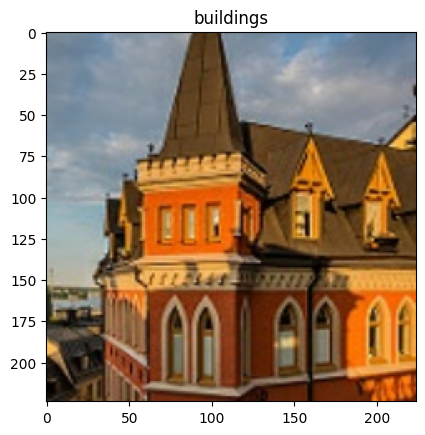

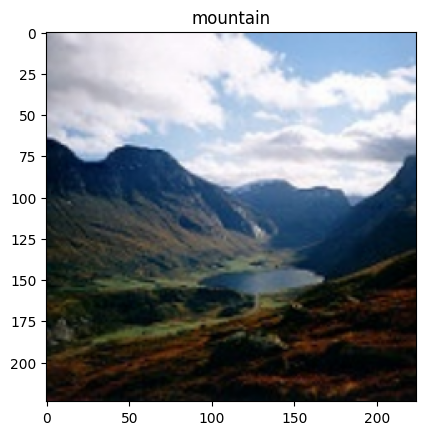

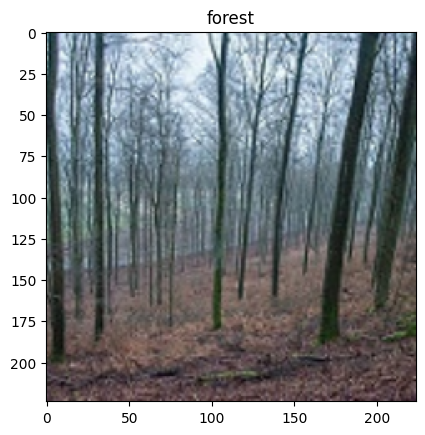

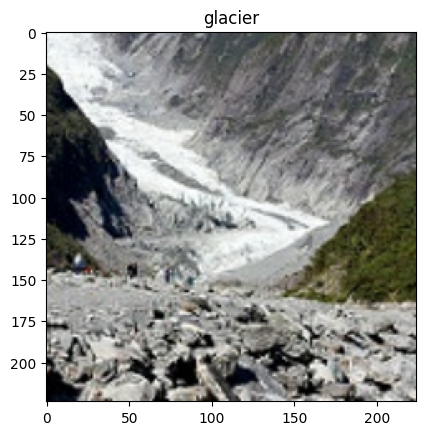

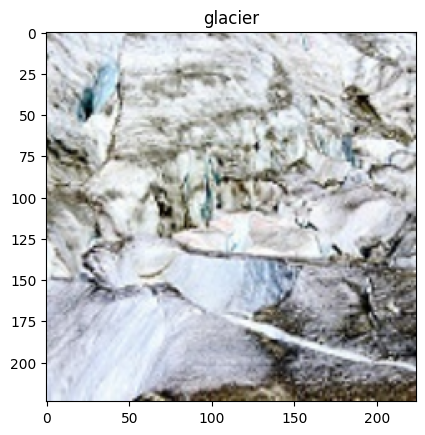

In [10]:
##### CODE HERE #####

# 이미지 강제 resize에 따른
# 인터폴레이션 : : 이미지를 재조정할 때 사용되는 방법 중 하나로, 인터폴레이션(interpolation)은 원본 이미지에서 새로운 픽셀 값을 추정하여 이미지의 크기를 변경합니다.
# 엑스트라폴레이션
for images, labels in train_ds.take(5): 
    # train_ds 데이터셋에서 5개의 배치를 가져옵니다. 
    # 이 반복문은 그 중 첫 번째 배치부터 시작하여 총 5번 반복하면서 각 배치의 이미지와 라벨을 images와 labels 변수에 저장합니다.
    plt.imshow(images[0].numpy().astype('uint8'))
    plt.title(classes[labels[0]])
    plt.show()

## Step 2. Pretrained MobileNetV3로 Training 하기
이번 Step에서는 MobileNetV3를 이용하여 image classification을 학습해보겠습니다.

    - pretrained MobileNetV3는 tensorflow.keras.applications에서 기본으로 제공합니다.
    - 아래와 같이 pretrained MobileNetV3 model을 다운받습니다.
  

In [64]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
mobilenetv3 = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(RES, RES, 3)) 

# include_top=False : 마지막 classification 하는 Dense레이어는 불러오지 않음
# imagenet은 class 1000개짜리 문제를 푸는 모델인데 지금은 class 6개만 분류하는거라 따로 만들어야함

"""
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
여기서는 MobileNetV3 모델에 이미지를 입력하기 전에 적절한 전처리를 수행하는 함수 preprocess_input을 임포트합니다. 
각 모델에는 해당 모델의 학습에 사용되었던 것과 동일한 방식으로 입력 데이터를 전처리하는 고유한 함수가 있습니다.


MobileNetV3Small 클래스의 인스턴스를 생성합니다. 이 때 몇 가지 주요 인자를 설정합니다:
    - weights='imagenet': 모델의 가중치로 ImageNet 데이터셋으로 사전 훈련된 가중치를 사용합니다. 
                          이렇게 하면 풍부한 특징을 가진 가중치로 모델을 초기화할 수 있습니다.

    - include_top=False: 모델의 상단에 있는 완전 연결 레이어(fully connected layers)를 포함하지 않습니다. 
                         이 옵션은 주로 모델을 커스텀 데이터셋에 맞춰서 미세 조정(fine-tuning)할 때 사용됩니다.
"""

In [65]:
mobilenetv3.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['input_10[0][0]']            
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_3[0][0]']         
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                         

### 문제 6. Intel image classification을 위한 MobileNetV3 model 만들기    
    - functional API를 활용하여 6개의 class를 classification하는 model을 만들어봅시다.
    - fully connected layer는 1개만 추가하고, batchnorm을 사용합니다.
    - MobileNetV3에 data가 들어가기 전에 preprocess_input을 적용하여 input data가 preprocessing될 수 있도록 합니다.

In [66]:
##### CODE HERE #####

def create_model():
    inputs = keras.Input(shape = (RES, RES, 3))
    x = preprocess_input(inputs)
    x = mobilenetv3(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(units = N_CLASS)(x)
    x = BatchNormalization()(x)    
    outputs = Softmax()(x)
    model = keras.Model(inputs = inputs, outputs = outputs)
    return model


"""
- `x = preprocess_input(inputs)`:
   - `preprocess_input` 함수를 사용하여 입력 이미지 데이터를 전처리합니다. 
      이는 모델이 학습될 때 사용된 방식과 동일하게 데이터를 정규화하여 모델의 성능을 최적화하는 데 도움이 됩니다.

- `x = mobilenetv3(x)`:
   - 사전 훈련된 MobileNetV3Small 모델을 사용하여 입력 데이터를 통과시키고, 이를 통해 추출된 특징을 다음 층으로 전달합니다.

- `x = GlobalAveragePooling2D()(x)`:
   - `GlobalAveragePooling2D` 층을 사용하여 특징 맵(feature maps)의 평균을 구하여 각 맵에 대해 단일 값을 추출합니다. 
      이는 모델이 이미지의 공간적 차원을 압축하면서 중요한 정보는 보존하는 데 도움이 됩니다.

- `x = BatchNormalization()(x)`:
   - `BatchNormalization` 층을 적용하여 이전 층의 출력을 정규화합니다. 
      이 과정은 훈련 중에 내부 공변량 변화(internal covariate shift) 문제를 완화하고, 학습 속도를 향상시키는 데 도움이 됩니다.

### GlobalAveragePooling2D
 `GlobalAveragePooling2D`는 컨볼루션(convolutional) 신경망에서 특징 맵(feature maps)을 하나의 벡터로 압축하는 방법 중 하나입니다. 이 연산은 각 특징 맵 내의 평균을 계산하여, 각 맵에 대해 하나의 숫자(즉, 평균)만을 출력합니다.
 이렇게 하면 각 특징 맵에서 공간적 차원을 제거하고, 각 맵의 글로벌 평균을 유지하게 됩니다. 이것은 전통적인 완전 연결 레이어(Fully Connected Layer)를 사용하는 대신에 모델의 파라미터 수를 대폭 줄이고, 과적합(overfitting)을 방지하는 데 도움이 됩니다.
 예를 들어, 입력 특징 맵이 `[batch_size, height, width, channels]`의 형태를 가진다면, `GlobalAveragePooling2D`를 거친 후의 출력 형태는 `[batch_size, channels]`가 됩니다. 여기서 각 채널은 해당 특징 맵의 평균 값을 가지게 됩니다.

 
### BatchNormalization
 `BatchNormalization`은 신경망에서 학습 과정을 가속화하고 안정화하는 데 도움이 되는 기술입니다. 이 층은 네트워크의 각 배치에 대해 입력을 정규화하는 작업을 수행합니다. 정규화는 입력의 평균을 0으로 만들고, 표준편차를 1로 만드는 과정을 말합니다.
 이 기법은 신경망이 각 레이어를 통과할 때 입력 데이터의 분포가 변하는 ‘내부 공변량 변화(internal covariate shift)’ 문제를 해결하기 위해 도입되었습니다. 이 변화를 줄이면, 학습률을 높게 설정할 수 있고, 가중치 초기화에 덜 민감하며, 종종 정규화(regularization) 효과도 나타나서 과적합을 줄이는 데 도움이 됩니다.
 `BatchNormalization` 층은 각 배치에서 평균과 분산을 계산하고, 이를 사용하여 정규화 과정을 수행합니다. 그 다음, 학습 가능한 파라미터를 사용하여 각각의 정규화된 데이터를 스케일링(scale)과 시프팅(shift)하여 네트워크가 필요한 경우 원래의 데이터 분포로 돌아갈 수 있게 합니다.
"""

In [25]:
model = create_model()

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 576)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 6)                 3462      
                                                                 
 batch_normalization (Batch  (None, 6)                 24        
 Normalization)                                                  
                                                             

  ### 문제 7. 학습하기
    - SGD를 사용하여 model을 학습합니다.(총 epoch수는 N_EPOCH으로 설정)
    - learning rate은 위에서 정한 hyperparameter(LR)을 사용합니다.
    - loss는 cross entropy를 사용합니다.

In [27]:
##### CODE HERE #####
model.compile(
    # keras.optimizers.SGD(learning_rate=LR), # m1 MAC 에서 느리게 실행됨
    keras.optimizers.legacy.SGD(learning_rate=LR), 
    loss = keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'])

In [28]:
model.fit(train_ds, 
          epochs=N_EPOCH, 
          validation_data=val_ds)

Epoch 1/50


2023-11-07 15:09:02.217373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


220/220 [==============================] - ETA: 0s - loss: 2.2084 - accuracy: 0.1516

2023-11-07 15:09:47.057281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


220/220 [==============================] - 50s 181ms/step - loss: 2.2084 - accuracy: 0.1516 - val_loss: 1.9633 - val_accuracy: 0.1993
Epoch 2/50
220/220 [==============================] - 34s 155ms/step - loss: 1.9854 - accuracy: 0.2210 - val_loss: 1.7915 - val_accuracy: 0.2793
Epoch 3/50
220/220 [==============================] - 34s 156ms/step - loss: 1.7841 - accuracy: 0.2931 - val_loss: 1.6235 - val_accuracy: 0.3523
Epoch 4/50
220/220 [==============================] - 34s 157ms/step - loss: 1.6227 - accuracy: 0.3559 - val_loss: 1.4848 - val_accuracy: 0.4227
Epoch 5/50
220/220 [==============================] - 34s 155ms/step - loss: 1.4921 - accuracy: 0.4172 - val_loss: 1.3759 - val_accuracy: 0.4813
Epoch 6/50
220/220 [==============================] - 34s 155ms/step - loss: 1.3892 - accuracy: 0.4660 - val_loss: 1.2917 - val_accuracy: 0.5287
Epoch 7/50
220/220 [==============================] - 34s 153ms/step - loss: 1.3081 - accuracy: 0.5108 - val_loss: 1.2258 - val_accuracy: 0.5

### 문제 8. Optimizer 변경하기
    - 같은 model에서 optimizer만 Adam으로 변경하여 학습해봅시다.

In [67]:
##### CODE HERE #####
model = create_model()

In [68]:
model.compile(
    keras.optimizers.Adam(learning_rate=LR), 
    loss = keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'])

In [69]:
model.fit(train_ds, epochs=N_EPOCH, validation_data=val_ds)

Epoch 1/50


2023-11-07 15:43:37.577792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


220/220 [==============================] - ETA: 0s - loss: 0.8142 - accuracy: 0.7893

2023-11-07 15:44:17.906219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


220/220 [==============================] - 47s 184ms/step - loss: 0.8142 - accuracy: 0.7893 - val_loss: 0.7561 - val_accuracy: 0.8593
Epoch 2/50
220/220 [==============================] - 35s 159ms/step - loss: 0.5181 - accuracy: 0.9137 - val_loss: 0.6690 - val_accuracy: 0.8983
Epoch 3/50
220/220 [==============================] - 35s 159ms/step - loss: 0.4611 - accuracy: 0.9286 - val_loss: 0.6009 - val_accuracy: 0.9173
Epoch 4/50
220/220 [==============================] - 36s 161ms/step - loss: 0.4147 - accuracy: 0.9407 - val_loss: 0.5746 - val_accuracy: 0.9187
Epoch 5/50
220/220 [==============================] - 35s 159ms/step - loss: 0.3857 - accuracy: 0.9486 - val_loss: 0.5404 - val_accuracy: 0.9247
Epoch 6/50
220/220 [==============================] - 34s 156ms/step - loss: 0.3594 - accuracy: 0.9570 - val_loss: 0.5152 - val_accuracy: 0.9300
Epoch 7/50
220/220 [==============================] - 35s 160ms/step - loss: 0.3324 - accuracy: 0.9652 - val_loss: 0.4973 - val_accuracy: 0.9

## Step3. Model 성능 올리기

이번 Step에서는 다양한 방법을 사용하여 MobileNetV3의 성능을 올려보도록 하겠습니다.

### 문제 9. Data augmentation 사용하기
    - training data에 data augmentation을 적용해봅시다.
    - dataset을 만들 때 training data를 256x256으로 resize합니다.
    - augmentation function을 만들고, 224x224로 random crop합니다.
    - horizontal flip도 random으로 적용합니다.
    - augmentation을 하였으므로 training epoch을 100으로 키웁니다.
    - optimizer와 다른 hyperparameter는 수정하지 않고 training합니다.

In [70]:
##### CODE HERE #####
RES_BEF = 256
N_EPOCH = 100

In [71]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=(RES_BEF, RES_BEF),
    batch_size=N_BATCH
)

Found 14034 files belonging to 6 classes.


In [72]:
def aug(image, label):
    image = tf.image.random_crop(image, [RES, RES, 3])
    image = tf.image.random_flip_left_right(image)
    return image, label

"""
1. `image = tf.image.random_crop(image, [RES, RES, 3])`:
   - `tf.image.random_crop` 함수는 입력 이미지를 무작위로 크롭합니다. `[RES, RES, 3]`는 크롭된 이미지의 크기를 정의하는데, 여기서 `RES`는 크롭할 높이와 너비를, `3`은 채널의 수를 나타냅니다. 
   - 이 작업은 원본 이미지에서 무작위 위치를 선택하고, 거기서부터 `RES`x`RES` 크기의 부분 이미지를 잘라냅니다. 이를 통해 모델이 이미지의 특정 부분에 의존하지 않고 전체 이미지의 다양한 영역에서 특징을 학습하도록 돕습니다.

2. `image = tf.image.random_flip_left_right(image)`:
   - `tf.image.random_flip_left_right` 함수는 이미지를 수평으로 무작위로 뒤집습니다. 즉, 이미지의 왼쪽과 오른쪽을 무작위로 바꿉니다.
   - 이 과정은 이미지를 좌우 대칭으로 변환하여, 모델이 좌우 방향에 대해 불변성을 갖도록 만듭니다. 예를 들어, '고양이' 이미지가 뒤집혔을 때에도 모델이 '고양이'로 인식할 수 있도록 학습하는 데 도움이 됩니다.
"""

In [73]:
train_ds = train_ds.unbatch().map(aug, num_parallel_calls = AUTOTUNE).batch(N_BATCH, drop_remainder=True).prefetch(AUTOTUNE)


"""
이 코드 라인은 데이터 증강 과정을 학습 데이터셋(`train_ds`)에 적용하기 위한 TensorFlow 파이프라인을 설정합니다. 각 함수와 메서드는 특정한 작업을 수행하여 데이터를 모델 학습에 적합한 형태로 준비합니다.

1. `train_ds.unbatch()`:
   - `unbatch` 메서드는 배치된 데이터셋을 개별 데이터 샘플로 해체합니다. 데이터셋이 배치 형태로 되어 있다면, `unbatch`를 호출하여 각 이미지를 개별적으로 처리할 수 있습니다.

2. `.map(aug, num_parallel_calls=AUTOTUNE)`:
   - `map` 메서드는 데이터셋의 각 항목에 함수를 적용합니다. 여기서는 `aug` 함수를 사용하여 데이터 증강을 적용합니다.
   - `num_parallel_calls=AUTOTUNE`은 데이터 처리를 위해 여러 쓰레드를 사용하고, TensorFlow가 자동으로 필요한 쓰레드 수를 동적으로 결정하도록 설정합니다. 이렇게 함으로써 데이터 로딩과 전처리가 학습 과정을 지연시키지 않도록 최적화합니다.

3. `.batch(N_BATCH, drop_remainder=True)`:
   - `batch` 메서드는 개별 데이터 샘플들을 다시 배치(batch) 형태로 묶습니다. `N_BATCH`는 한 배치에 포함될 샘플의 수를 정의합니다.
   - `drop_remainder=True` 옵션은 마지막 배치가 `N_BATCH`보다 작을 경우 이를 버립니다. 이는 모델이 일정한 배치 크기로만 작동해야 할 때 유용하며, 일부 모델 아키텍처에서는 필수적일 수 있습니다.

4. `.prefetch(AUTOTUNE)`:
   - `prefetch` 메서드는 학습 중에 GPU가 데이터를 기다리지 않도록 다음 배치를 미리 준비합니다.
   - `AUTOTUNE`은 TensorFlow에게 이 작업에 필요한 리소스 양을 자동으로 결정하게 합니다.
"""

In [74]:
model = create_model()
model.compile(
    keras.optimizers.Adam(learning_rate=LR),
    loss=keras.losses.SparseCategoricalCrossentropy,
    metrics=['accuracy']
)

In [75]:
model.fit(
    train_ds,
    epochs=N_EPOCH,
    validation_data=val_ds
)

Epoch 1/100


TypeError: in user code:

    File "/Users/mac/anaconda3/envs/api/lib/python3.8/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/Users/mac/anaconda3/envs/api/lib/python3.8/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/mac/anaconda3/envs/api/lib/python3.8/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/Users/mac/anaconda3/envs/api/lib/python3.8/site-packages/keras/src/engine/training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/mac/anaconda3/envs/api/lib/python3.8/site-packages/keras/src/engine/training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "/Users/mac/anaconda3/envs/api/lib/python3.8/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/mac/anaconda3/envs/api/lib/python3.8/site-packages/keras/src/losses.py", line 160, in __call__
        return losses_utils.compute_weighted_loss(
    File "/Users/mac/anaconda3/envs/api/lib/python3.8/site-packages/keras/src/utils/losses_utils.py", line 328, in compute_weighted_loss
        losses = tf.convert_to_tensor(losses)

    TypeError: Failed to convert elements of <keras.src.losses.SparseCategoricalCrossentropy object at 0x2ce24e6d0> to Tensor. Consider casting elements to a supported type. See https://www.tensorflow.org/api_docs/python/tf/dtypes for supported TF dtypes.


### 문제 10. cutmix 알고리즘 구현을 위한 dataset 재생성
    - data augmentation 방법 중 하나인 cutmix를 구현해봅시다.
    - 논문은 https://arxiv.org/abs/1905.04899 에서 확인할 수 있습니다.
    - 알고리즘에 대한 간략한 설명은 맨 첫부분에 이론강의로 제공되니, 강의를 시청하고 문제를 푸는 것도 좋습니다.

    - cutmix를 위해서는 사전에 label이 one-hot encoding되어 있어야 하므로, dataset을 수정하여 label이 one-hot이 되도록 합니다.

In [ ]:
##### CODE HERE #####

train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=(RES_BEF, RES_BEF),
    label_mode='categorical',
    batch_size=N_BATCH
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle=False,
    image_size=(RES_BEF, RES_BEF),
    label_mode='categorical',
    batch_size=N_BATCH
)

"""
label_mode: 레이블을 어떤 형태로 생성할지를 결정합니다. 
'categorical'은 레이블을 원-핫 인코딩 형태로 만듭니다. 
예를 들어, 3개의 클래스가 있는 경우, 각 클래스는 [1, 0, 0], [0, 1, 0], [0, 0, 1]와 같이 표현됩니다.
"""

    - 아래 코드를 실행하여 제대로 one-hot encoding이 되어있는지 확인해봅시다

In [ ]:
for images, labels in train_ds.take(1):  
  print(labels[0].numpy())
for images, labels in val_ds.take(1):  
  print(labels[0].numpy())

### 문제 11. cutmix 알고리즘 구현
    - cutmix 알고리즘을 구현해봅시다.
    - cutmix라는 함수를 만들어서 구현합니다.
    - 위에서 생성한 dataset에 map으로 적용할 수 있도록 images, labels를 입력으로 받습니다.

In [ ]:
##### CODE HERE #####

def cutmix(images, labels):
    imgs = []; labs = []
    
    # N_BATCH 크기만큼의 반복문을 실행하여 각 배치의 이미지에 대해 CutMix를 적용합니다.
    for i in range(N_BATCH):
        # `APPLY`는 0과 1 사이에서 무작위 값을 추출하고, 이 값이 0.5 이상인 경우에만 CutMix를 적용할지를 결정하는 이진 플래그입니다.
        APPLY = tf.cast(tf.random.uniform(()) >= 0.5, tf.int32)
        # `idx`는 무작위로 선택한 인덱스로, 현재 이미지와 섞을 다른 이미지를 결정합니다.
        idx = tf.random.uniform((), 0, N_BATCH, tf.int32) # 끼워 넣어 줄 이미지

        W = RES
        H = RES

        # `lam`은 베타 분포에서 추출한 랜덤 변수로, 섞는 비율을 결정합니다. `cut_w`와 `cut_h`는 섞을 영역의 너비와 높이를 결정합니다.
        """
        **랜덤 변수 `lam` 생성**:
            - `lam`은 `tf.random.uniform(())` 함수를 사용하여 0과 1 사이의 균등 분포에서 랜덤한 값을 생성합니다. 이 값은 두 이미지를 합칠 때 각각의 이미지에서 얼마나 많은 영역을 차지할지를 결정합니다.
        """
        lam = tf.random.uniform(())


        """
        **자르는 영역의 비율 계산**:
            - `cut_ratio`는 `lam` 값에 1을 뺀 후 제곱근을 취하여 계산합니다. 이 값은 두 번째 이미지에서 잘라낼 영역의 비율을 결정합니다.
        """
        cut_ratio = tf.math.sqrt(1. - lam)


        """
        **자르는 영역의 너비(`cut_w`)와 높이(`cut_h`) 결정**:
           - `cut_w`와 `cut_h`는 전체 이미지의 너비(`W`)와 높이(`H`)에 `cut_ratio`를 곱한 값입니다. 결과를 정수로 변환하기 전에 `APPLY` 플래그와 곱하여, CutMix를 적용하지 않는 경우 영역의 크기가 0이 되도록 합니다.
        """
        cut_w = tf.cast(W * cut_ratio, tf.int32) * APPLY
        cut_h = tf.cast(H * cut_ratio, tf.int32) * APPLY


        # `cx`와 `cy`는 섞을 영역의 중심 좌표를 무작위로 결정합니다.
        """
        **자르는 영역의 중심 좌표(`cx`, `cy`) 결정**:
           - `cx`와 `cy`는 각각 자르는 영역의 중심이 될 x, y 좌표를 무작위로 결정합니다. 여기서는 전체 이미지의 1/8에서 7/8 사이의 값으로 설정하여, 자르는 영역이 이미지의 가장자리에 너무 치우치지 않도록 합니다.
        """
        cx = tf.random.uniform((), int(W / 8), int(7 / 8*W), tf.int32)
        cy = tf.random.uniform((), int(H / 8), int(7 / 8*H), tf.int32)

        # `xmin`, `ymin`, `xmax`, `ymax`는 섞을 영역의 사각형 좌표를 계산합니다.
        """
        **자르는 영역의 실제 좌표(`xmin`, `ymin`, `xmax`, `ymax`) 계산**:
           - `cx`와 `cy`를 중심으로 하여, 계산된 `cut_w`와 `cut_h`를 이용하여 자르는 영역의 실제 좌표를 계산합니다. `tf.clip_by_value` 함수는 좌표가 이미지 범위를 벗어나지 않도록 합니다.
        """
        xmin = tf.clip_by_value(cx - cut_w // 2, 0, W)
        ymin = tf.clip_by_value(cy - cut_h // 2, 0, H)
        xmax = tf.clip_by_value(cx + cut_w // 2, 0, W)
        ymax = tf.clip_by_value(cy + cut_h // 2, 0, H)
        
        # (N, H, W, C)
        # 이미지 섹션들을 잘라내고 재조합하여 새로운 이미지를 생성합니다. 중간 부분은 다른 이미지의 `idx`에서 추출하고, 나머지 부분은 현재 이미지에서 추출합니다.
        """
        **새 이미지 구성**:
           - 새로운 이미지를 생성하기 위해, 원본 이미지(`images[i]`)와 다른 이미지(`images[idx]`)에서 해당하는 부분을 잘라내고 합칩니다. 이 과정에서 원본 이미지의 왼쪽과 오른쪽, 그리고 상단과 하단 부분을 유지하고 중앙 부분만 다른 이미지의 해당 영역으로 대체합니다.

        1. **이미지를 세로 방향으로 분할**:
           - `mid_left`: 현재 이미지(`images[i]`)에서 잘라내기 위한 영역(`ymin`부터 `ymax`)의 왼쪽 부분(`xmin` 이전)을 선택합니다.
           - `mid_mid`: 다른 이미지(`images[idx]`)에서 같은 영역의 중앙 부분(`xmin`부터 `xmax`)을 선택합니다. 이 부분이 다른 이미지로부터 잘라내서 삽입될 부분입니다.
           - `mid_right`: 현재 이미지에서 잘라내기 영역의 오른쪽 부분(`xmax` 이후)을 선택합니다.

        2. **중앙 섹션을 수평으로 연결**:
           - `tf.concat([mid_left, mid_mid, mid_right], axis=1)`: 이 세 부분을 수평 방향(axis=1)으로 연결하여 하나의 중앙 섹션을 만듭니다. 이렇게 함으로써 잘라내고 삽입할 부분을 포함한 새로운 가로 줄이 생성됩니다.

        3. **상단과 하단 섹션을 선택**:
           - `top`: 현재 이미지에서 잘라내기 영역의 위쪽 부분을 선택합니다(`ymin` 이전).
           - `bottom`: 현재 이미지에서 잘라내기 영역의 아래쪽 부분을 선택합니다(`ymax` 이후).

        4. **새로운 이미지를 세로 방향으로 연결**:
           - `tf.concat([top, middle, bottom], axis=0)`: 상단 부분, 중앙 부분(이미 수평으로 연결된), 그리고 하단 부분을 세로 방향(axis=0)으로 연결하여 새로운 이미지를 생성합니다.

        5. **새 이미지를 리스트에 추가**:
           - `imgs.append(new_img)`: 생성된 새 이미지를 `imgs` 리스트에 추가합니다. 이 리스트는 나중에 모든 새 이미지들을 한 배치로 결합하기 위해 사용됩니다.
        """
        mid_left = images[i, ymin:ymax, :xmin, :]
        mid_mid = images[idx, ymin:ymax, xmin:xmax, :]
        mid_right = images[i, ymin:ymax, xmax:, :]
        middle = tf.concat([mid_left, mid_mid, mid_right], axis = 1)
        top = images[i, :ymin, :, :]
        bottom = images[i, ymax:, :, :]
        
        # `new_img`는 위에서 아래로 세 부분을 연결하여 새로운 이미지를 생성합니다.
        new_img = tf.concat([top, middle, bottom], axis = 0)
        imgs.append(new_img)


        """
        **새 레이블 계산**:
            - `alpha`는 합성된 이미지 내에서 두 번째 이미지가 차지하는 영역의 비율을 계산합니다. 이는 자른 영역의 너비와 높이를 원본 이미지의 너비와 높이로 나눈 값으로, 새 레이블을 계산할 때 사용됩니다.
            - `new_label`은 원본 이미지의 레이블(`label1`)과 다른 이미지의 레이블(`label2`)을 `alpha` 값에 따라 가중 평균하여 합칩니다. 결과적으로 합성된 이미지에 대한 레이블이 두 이미지의 특성을 반영하게 됩니다.

        `xmax - xmin` 연산은 이미지의 세로 방향에서 잘라낸 부분의 넓이(Width)를 계산합니다. 유사하게, `ymax - ymin` 연산은 잘라낸 부분의 높이(Height)를 계산합니다. 
        여기서 `xmin`과 `xmax`는 잘라낸 부분의 좌우 경계를 나타내고, `ymin`과 `ymax`는 잘라낸 부분의 상하 경계를 나타냅니다. 이렇게 계산된 넓이와 높이는 잘라낸 영역의 실제 크기를 의미하며, 이 정보는 두 이미지의 레이블을 혼합할 때 사용되는 가중치인 `alpha` 값을 계산하는 데 사용됩니다.
        이 가중치는 원본 이미지 영역과 새로 삽입된 영역 간의 비율을 결정하고, 최종적으로 혼합된 레이블을 생성할 때 사용됩니다. 예를 들어, 만약 새로 삽입된 영역이 전체 이미지 영역의 25%를 차지한다면, `alpha` 값은 0.25가 될 것이고, 새로운 레이블은 원본 이미지 레이블의 75%와 새 이미지 레이블의 25%를 반영하게 됩니다.
        """
        cut_w_mod = xmax - xmin # 넓비
        cut_h_mod = ymax - ymin # 높이
        # `alpha`는 새 이미지에서 원본 이미지의 영역 비율을 계산합니다.
        alpha = tf.cast((cut_w_mod * cut_h_mod) / (W * H), tf.float32)
        
        label1 = labels[i]
        label2 = labels[idx]

        # `new_label`은 두 이미지의 레이블을 `alpha`에 따라 섞어 새 레이블을 생성합니다.
        new_label = ((1 - alpha) * label1 + alpha * label2)

        labs.append(new_label)

    new_imgs = tf.reshape(tf.stack(imgs), [-1, RES, RES, 3])
    new_labs = tf.reshape(tf.stack(labs), [-1, N_CLASS])

    return new_imgs, new_labs

In [16]:
import tensorflow as tf

# Set the hypothetical values for demonstration
W = H = 800  # width and height of the image
N_BATCH = 5  # number of images in the batch
RES = W  # resolution, assuming square images

# Example tensors for images and labels (placeholders for demonstration)
images = tf.random.uniform((N_BATCH, RES, RES, 3), 0, 255, dtype=tf.int32)
labels = tf.random.uniform((N_BATCH, 10), 0, 1)  # Assuming 10 classes for labels

# Placeholder lists for new images and labels
imgs = []; labs = []

# CutMix operation
for i in range(1):
    APPLY = 1
    idx = tf.random.uniform((), 0, N_BATCH, tf.int32)

    lam = tf.random.uniform(())
    cut_ratio = tf.math.sqrt(1.-lam)
    cut_w = tf.cast(W * cut_ratio, tf.int32) * APPLY
    cut_h = tf.cast(H * cut_ratio, tf.int32) * APPLY

    cx = tf.random.uniform((), int(W/8), int(7/8*W), tf.int32)
    cy = tf.random.uniform((), int(H/8), int(7/8*H), tf.int32)

    xmin = tf.clip_by_value(cx - cut_w//2, 0, W)
    ymin = tf.clip_by_value(cy - cut_h//2, 0, H)
    xmax = tf.clip_by_value(cx + cut_w//2, 0, W)
    ymax = tf.clip_by_value(cy + cut_h//2, 0, H)

    # For demonstration, we'll print the calculated values in the first iteration

    print(f"APPLY: {APPLY}")
    print(f"idx: {idx}")
    print(f"lam: {lam}")
    print(f"cut_ratio: {cut_ratio}")
    print(f"cut_w: {cut_w}")
    print(f"cut_h: {cut_h}")
    print(f"cx: {cx}")
    print(f"cy: {cy}")
    print(f"xmin: {xmin}")
    print(f"ymin: {ymin}")
    print(f"xmax: {xmax}")
    print(f"ymax: {ymax}")

# The rest of the function is omitted for brevity

# Note: This is just a demonstration with randomly generated values.
#       The actual values will differ every time the code is run.



APPLY: 1
idx: 1
lam: 0.3117929697036743
cut_ratio: 0.8295824527740479
cut_w: 663
cut_h: 663
cx: 554
cy: 131
xmin: 223
ymin: 0
xmax: 800
ymax: 462


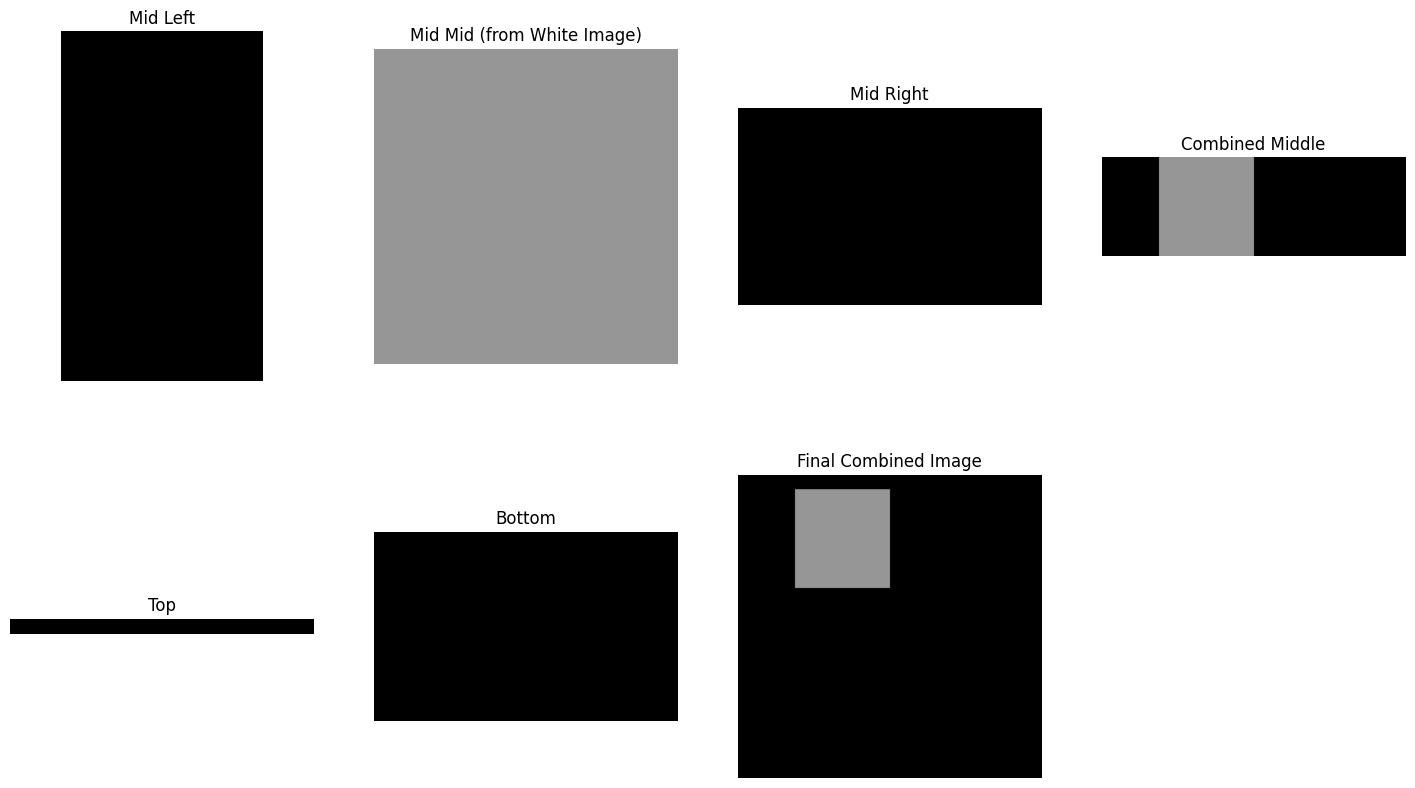

In [27]:
import numpy as np
import matplotlib.pyplot as plt
# 이미지 생성 (검은색과 흰색 이미지)
black_image = np.zeros((800, 800, 3), dtype=np.uint8)
white_image = np.ones((800, 800, 3), dtype=np.uint8) * 150

# 임의의 절단 영역 설정
xmin, xmax = 150, 400
ymin, ymax = 40, 300

# 각 부분 추출
mid_left = black_image[ymin:ymax, :xmin, :]
mid_mid = white_image[ymin:ymax, xmin:xmax, :]
mid_right = black_image[ymin:ymax, xmax:, :]
middle = np.concatenate([mid_left, mid_mid, mid_right], axis=1)
top = black_image[:ymin, :, :]
bottom = black_image[ymax:, :, :]

# 새로운 이미지 생성
new_image = np.concatenate([top, middle, bottom], axis=0)

# 시각화
plt.figure(figsize=(18, 10))

# 중간 부분의 왼쪽, 중간, 오른쪽 시각화
plt.subplot(2, 4, 1)
plt.imshow(mid_left)
plt.title("Mid Left")
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(mid_mid)
plt.title("Mid Mid (from White Image)")
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(mid_right)
plt.title("Mid Right")
plt.axis('off')

# 중간 부분 조합
plt.subplot(2, 4, 4)
plt.imshow(middle)
plt.title("Combined Middle")
plt.axis('off')

# 상단 부분
plt.subplot(2, 4, 5)
plt.imshow(top)
plt.title("Top")
plt.axis('off')

# 하단 부분
plt.subplot(2, 4, 6)
plt.imshow(bottom)
plt.title("Bottom")
plt.axis('off')

# 최종 이미지
plt.subplot(2, 4, 7)
plt.imshow(new_image)
plt.title("Final Combined Image")
plt.axis('off')

plt.show()


In [30]:
import numpy as np
import tensorflow as tf

# 임의의 이미지 5장 생성 (여기서는 단순히 랜덤 값으로)
images = [np.random.rand(100, 100, 3) for _ in range(5)]

# append를 사용하여 리스트에 이미지 추가
append_images = []
for img in images:
    append_images.append(img)

# tf.stack을 사용하여 텐서로 쌓기
stacked_images = tf.stack(images)

# 결과 출력
print("With append:")
print(f"Shape: {append_images.shape}")
for i, img in enumerate(append_images):
    print(f"Image {i}: Type: {type(img)}, Shape: {img.shape}")

print("\nWith tf.stack:")
print(f"Stacked images: Type: {type(stacked_images)}, Shape: {stacked_images.shape}")


With append:


AttributeError: 'list' object has no attribute 'shape'

### 문제 12. cutmix 적용 및 확인
    - 작성한 cutmix 알고리즘을 train_ds에 적용하고, 문제 5에서와 같이 확인해봅니다.
    - 앞에서 적용했던 random crop과 random flip도 함께 적용합니다.

In [ ]:
##### CODE HERE #####

train_ds = train_ds.unbatch().map(
                                aug, 
                                num_parallel_calls = AUTOTUNE).batch(
                                                                N_BATCH, 
                                                                drop_remainder = True).map(
                                                                                        cutmix, num_parallel_calls = AUTOTUNE).prefetch(AUTOTUNE)

In [ ]:
for images, labels in train_ds.take(5):
    plt.imshow(images[0].numpy().astype('uint8'))
    print(labels[0].numpy())
    plt.show()

### 문제 13. cutmix 적용하여 training
    - model을 새로 생성하고 학습하여 결과를 확인해봅시다.
    - 다른 hyperparameter는 이전과 동일하게 하여 결과를 비교해봅시다.

In [ ]:
##### CODE HERE #####
model = create_model()

In [ ]:
model.compile(
    keras.optimizers.Adam(learning_rate=LR),
    loss = keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
model.fit(
    train_ds,
    epochs=N_EPOCH,
    validation_data=val_ds
)

### 문제 14. Bigger resolution
    - input image resolution을 320x320으로 키워봅시다.
    - random crop을 적용하기 전 resolution은 330x330으로 설정합니다.
    - resolution에 맞게 train_ds와 val_ds를 다시 생성하고, data augmentation을 동일하게 적용합니다.

  

In [32]:
##### CODE HERE #####
## Hyper-Parameter 설정
# image resolution
RES_BEF = 330
RES = 320
# class 수 
N_CLASS = 6
# batch size
N_BATCH = 64
# epoch 수
N_EPOCH = 100
# learning rate
LR = 0.0001

In [ ]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=(RES_BEF, RES_BEF),
    label_mode='categorical',
    batch_size=N_BATCH
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle=False,
    image_size=(RES_BEF, RES_BEF),
    label_mode='categorical',
    batch_size=N_BATCH
)

In [ ]:
train_ds = train_ds.unbatch().map(
                                aug, 
                                mum_parallel_calls = AUTOTUNE).batch(
                                                                N_BATCH, 
                                                                drop_remainder = True).map(
                                                                                        cutmix, 
                                                                                        num_parallel_calls = AUTOTUNE).prefetch(AUTOTUNE)

### 문제 15. Learning rate warmup + cosine decay 구현하기
    - custom learning rate scheduler를 만들어서 warm up과 cosine anealing을 구현해봅시다.
    - max_lr, warmup_steps, decay_steps 세가지 항목을 입력을 받을 수 있도록 합니다. 
    - max_lr은 최대 learning rate, warmup_steps는 warm up이 끝나는 step 수, decay steps는 cosine decay가 끝나는 step 수를 의미합니다.
    - keras.optimizers.schedules.LearningRateSchedule를 상속하여 subclass로 만듭니다.
    - 자세한 사항은 아래 링크들을 참고하시면 됩니다.
https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/LearningRateSchedule

https://www.tensorflow.org/tutorials/text/transformer

In [41]:
##### CODE HERE #####
from tensorflow import keras
class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, max_lr, warmup_steps, decay_steps):
    super(CustomSchedule, self).__init__()
    self.max_lr = max_lr
    self.warmup_steps = warmup_steps
    self.decay_steps = decay_steps

  def __call__(self, step):
        # tf.cond 함수는 TensorFlow의 조건문이며, 주어진 조건에 따라 두 개의 다른 연산 중 하나를 실행합니다.
        lr = tf.cond(step < self.warmup_steps, # pred: 불리언 타입의 조건입니다. 이 예에서는 step < self.warmup_steps가 해당되며, 현재 스텝이 웜업 스텝보다 작은지를 확인합니다.
                     lambda: self.max_lr / self.warmup_steps * step, # true_fn: pred가 참일 경우 실행될 함수입니다. 여기서는 람다 표현식 lambda: self.max_lr / self.warmup_steps * step를 사용하고 있습니다. 웜업 단계에서는 학습률이 선형적으로 증가합니다.
                     lambda: 0.5 * (1 + tf.math.cos(math.pi * (step - self.warmup_steps) / self.decay_steps)) * self.max_lr) # false_fn: pred가 거짓일 경우 실행될 함수입니다. 여기서는 람다 표현식 lambda: 0.5 * (1 + tf.math.cos(math.pi * (step - self.warmup_steps) / self.decay_steps)) * self.max_lr를 사용하고 있습니다. 웜업 단계 이후에는 코사인 감쇠 스케줄을 사용하여 학습률을 계산합니다.
        return lr

    

"""
`CustomSchedule` 클래스는 Keras의 `LearningRateSchedule`을 상속받아, 커스텀 학습률 스케줄을 구현하는 것입니다. 이 스케줄은 웜업 단계를 거친 후, 주어진 감쇠 단계에 따라 학습률이 감소하는 코사인 감쇠 스케줄을 사용합니다.

클래스는 다음과 같은 메소드와 속성을 갖습니다:
    - `__init__(self, max_lr, warmup_steps, decay_steps)`: 초기화 메소드로, 객체를 생성할 때 최대 학습률(`max_lr`), 웜업 단계(`warmup_steps`), 그리고 감쇠 단계(`decay_steps`)를 설정합니다.
    - `__call__(self, step)`: 객체가 호출될 때(함수처럼) 실행되는 메소드로, 현재 스텝(`step`)에 따라 계산된 학습률을 반환합니다.

학습률은 다음과 같이 계산됩니다:

1. 웜업 단계(`step < self.warmup_steps`): 초기 스텝에서 학습률은 선형적으로 `self.max_lr`까지 증가합니다. 즉, 각 스텝에서의 학습률은 `self.max_lr`을 웜업 스텝 수로 나눈 값에 현재 스텝 수를 곱한 값입니다.

2. 웜업 이후: 웜업 단계가 끝난 후에는 코사인 감쇠 함수를 사용해 학습률이 감소합니다. 이는 `0.5 * (1 + tf.math.cos(math.pi * (step - self.warmup_steps) / self.decay_steps))`의 공식으로 계산되며, 여기에 최대 학습률(`self.max_lr`)을 곱해 최종 학습률을 결정합니다. 이 공식은 감쇠 단계 동안 학습률이 코사인 곡선을 따라 점점 감소하도록 설계되었습니다.

커스텀 학습률 스케줄을 사용함으로써, 모델의 학습 초기에는 빠르게 학습하고 이후에는 느리게 학습하여 보다 안정적인 수렴을 도모할 수 있습니다.
"""

'\n`CustomSchedule` 클래스는 Keras의 `LearningRateSchedule`을 상속받아, 커스텀 학습률 스케줄을 구현하는 것입니다. 이 스케줄은 웜업 단계를 거친 후, 주어진 감쇠 단계에 따라 학습률이 감소하는 코사인 감쇠 스케줄을 사용합니다.\n\n클래스는 다음과 같은 메소드와 속성을 갖습니다:\n    - `__init__(self, max_lr, warmup_steps, decay_steps)`: 초기화 메소드로, 객체를 생성할 때 최대 학습률(`max_lr`), 웜업 단계(`warmup_steps`), 그리고 감쇠 단계(`decay_steps`)를 설정합니다.\n    - `__call__(self, step)`: 객체가 호출될 때(함수처럼) 실행되는 메소드로, 현재 스텝(`step`)에 따라 계산된 학습률을 반환합니다.\n\n학습률은 다음과 같이 계산됩니다:\n\n1. 웜업 단계(`step < self.warmup_steps`): 초기 스텝에서 학습률은 선형적으로 `self.max_lr`까지 증가합니다. 즉, 각 스텝에서의 학습률은 `self.max_lr`을 웜업 스텝 수로 나눈 값에 현재 스텝 수를 곱한 값입니다.\n\n2. 웜업 이후: 웜업 단계가 끝난 후에는 코사인 감쇠 함수를 사용해 학습률이 감소합니다. 이는 `0.5 * (1 + tf.math.cos(math.pi * (step - self.warmup_steps) / self.decay_steps))`의 공식으로 계산되며, 여기에 최대 학습률(`self.max_lr`)을 곱해 최종 학습률을 결정합니다. 이 공식은 감쇠 단계 동안 학습률이 코사인 곡선을 따라 점점 감소하도록 설계되었습니다.\n\n커스텀 학습률 스케줄을 사용함으로써, 모델의 학습 초기에는 빠르게 학습하고 이후에는 느리게 학습하여 보다 안정적인 수렴을 도모할 수 있습니다.\n'

### 문제 16. Learning rate scheduling visualization
    - 위에서 작성한 learning rate scheduling class가 제대로 동작하는지 적당한 값을 넣고 graph를 그려서 확인해봅시다.

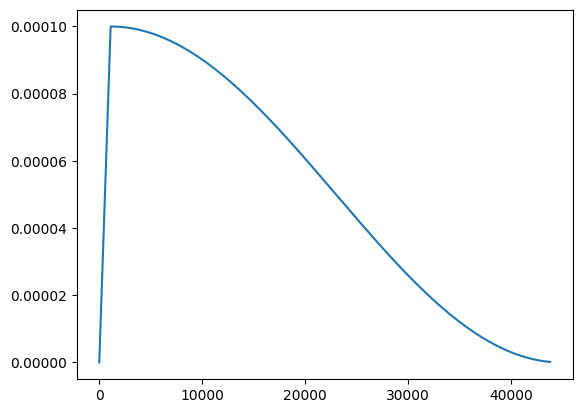

'\n1. `CustomSchedule` 클래스는 `max_lr`, `warmup_steps`, `decay_steps` 세 개의 매개변수를 가지고 있습니다.\n    - `max_lr`: 최대 학습률 값입니다.\n    - `warmup_steps`: 학습률이 선형적으로 증가하는 단계의 수입니다.\n    - `decay_steps`: 최대 학습률에서 시작하여 cosine decay를 적용하는 단계의 수입니다.\n\n2. `lr_schedule` 객체는 `CustomSchedule` 클래스의 인스턴스로, `steps_per_epoch`은 한 에포크당 스텝 수를 나타내며, 전체 데이터셋을 한 번 순회하는데 필요한 배치의 수입니다.\n\n3. `for` 루프는 0부터 `steps_per_epoch * 200`까지 반복하며, 이는 전체 트레이닝 스텝 수를 의미합니다. `lr_schedule(step)`을 호출하여 각 스텝에 대한 학습률을 계산하고 리스트 `lr`에 추가합니다.\n\n4. `step_list`는 1부터 시작하여 총 스텝 수를 나타내는 숫자의 리스트입니다. 이는 x축의 값으로 사용됩니다.\n\n5. 마지막으로 `matplotlib`의 `plot` 함수를 사용하여 스텝 수에 따른 학습률의 변화를 그래프로 그립니다.\n\n`plt.show()`는 그래프를 화면에 표시합니다. 이 그래프를 통해 학습률이 어떻게 변화하는지 직관적으로 이해할 수 있습니다. 초기에는 `warmup_steps` 동안 선형적으로 증가하다가, 이후에는 `decay_steps`에 따라 cosine 함수의 형태로 감소하는 패턴을 보일 것입니다.\n'

In [44]:
##### CODE HERE #####
steps_per_epoch = N_TRAIN // N_BATCH
lr_schedule = CustomSchedule(LR, 5*steps_per_epoch, 200*steps_per_epoch)

lr = []
for step in range(steps_per_epoch * 200):
    lr.append(lr_schedule(step))
step_list = list(np.arange(steps_per_epoch*200) + 1)

plt.plot(step_list, lr)
plt.show()

"""
1. `CustomSchedule` 클래스는 `max_lr`, `warmup_steps`, `decay_steps` 세 개의 매개변수를 가지고 있습니다.
    - `max_lr`: 최대 학습률 값입니다.
    - `warmup_steps`: 학습률이 선형적으로 증가하는 단계의 수입니다.
    - `decay_steps`: 최대 학습률에서 시작하여 cosine decay를 적용하는 단계의 수입니다.

2. `lr_schedule` 객체는 `CustomSchedule` 클래스의 인스턴스로, `steps_per_epoch`은 한 에포크당 스텝 수를 나타내며, 전체 데이터셋을 한 번 순회하는데 필요한 배치의 수입니다.

3. `for` 루프는 0부터 `steps_per_epoch * 200`까지 반복하며, 이는 전체 트레이닝 스텝 수를 의미합니다. `lr_schedule(step)`을 호출하여 각 스텝에 대한 학습률을 계산하고 리스트 `lr`에 추가합니다.

4. `step_list`는 1부터 시작하여 총 스텝 수를 나타내는 숫자의 리스트입니다. 이는 x축의 값으로 사용됩니다.

5. 마지막으로 `matplotlib`의 `plot` 함수를 사용하여 스텝 수에 따른 학습률의 변화를 그래프로 그립니다.

`plt.show()`는 그래프를 화면에 표시합니다. 이 그래프를 통해 학습률이 어떻게 변화하는지 직관적으로 이해할 수 있습니다. 초기에는 `warmup_steps` 동안 선형적으로 증가하다가, 이후에는 `decay_steps`에 따라 cosine 함수의 형태로 감소하는 패턴을 보일 것입니다.
"""

### 문제 17. Label smoothing 적용하여 학습하기
    - 위에서 새로 적용한 모든 것들(resolution, epoch 수, learning rate scheduling)을 다 반영하고, label smoothing까지 적용하여 학습해봅시다.
    - max_lr은 LR로, warmup_steps는 3 epoch에 해당하는 step수, decay_steps는 N_EPOCH에 해당하는 step수만큼으로 설정합니다.
    - label smoothing 값은 0.1로 설정합니다.

In [ ]:
##### CODE HERE #####
mobilenetv3 = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(RES, RES, 3))

In [ ]:
model = create_model()

In [ ]:
lr_schedule = CustomSchedule(LR, 3*steps_per_epoch, N_EPOCH * steps_per_epoch)
model.compile(keras.optimizers.Adam(lr_schedule),
              loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])


"""
여기에서 `CustomSchedule` 클래스를 사용하여 학습률 스케줄을 정의하고 이를 모델 컴파일 단계에서 옵티마이저로 전달하고 있습니다. 이는 모델의 학습 과정에서 사용될 동적인 학습률을 제공합니다.

`CustomSchedule`은 다음 매개변수를 받습니다:
- `LR`: 최대 학습률 값입니다.
- `3*steps_per_epoch`: 학습률이 점진적으로 증가할 초반 웜업 스텝의 총 수입니다. 여기서는 한 에포크당 스텝 수에 3을 곱한 값입니다.
- `N_EPOCH * steps_per_epoch`: 학습률 감소를 위한 전체 스텝 수입니다. 전체 에포크 수에 에포크당 스텝 수를 곱한 값입니다.

`model.compile()` 메서드는 모델을 훈련하기 전에 모델을 구성하는 데 사용됩니다. 여기서는 다음을 설정합니다:

- 옵티마이저로 `Adam`을 사용하며, 이 때 `lr_schedule`를 학습률 스케줄로 적용합니다.
- 손실 함수로 `CategoricalCrossentropy`를 사용하는데, 여기서 `label_smoothing=0.1` 파라미터를 사용하여 레이블 값을 약간 부드럽게 하여 모델이 너무 확신에 차지 않도록 돕습니다. 이는 과적합을 방지하는 데 도움을 줄 수 있습니다.
- 평가 지표(metrics)로 정확도(`'accuracy'`)를 사용하여 훈련 과정에서 모델의 성능을 추적합니다.

이렇게 구성된 모델은 `model.fit()`을 호출함으로써 훈련을 시작할 준비가 됩니다.
"""

In [ ]:
model.fit(
    train_ds,
    epochs=N_EPOCH,
    validation_data=val_ds
)

### 문제 18. Learning rate decay(계단식) 적용하여 학습하기
    - 계단식으로 learning rate decay를 적용해봅시다.
    - 매 30 epoch마다 1/10로 learning rate을 decay 시키도록 하여 학습해봅시다.
    - 구현은 keras.optimizers.schedules.ExponentialDecay API를 활용합니다.
https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay

In [ ]:
##### CODE HERE #####

model = create_model()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(LR, 
                                                          steps_per_epoch * 30,
                                                          0.1,
                                                          True)
"""
`keras.optimizers.schedules.ExponentialDecay` 클래스는 지수적 감소를 사용하여 각 epoch에 대한 학습률을 조정하는 방법을 제공합니다. 이를 사용하여 학습률이 지수적으로 감소하도록 설정할 수 있으며, 이는 훈련이 진행됨에 따라 모델이 더 미세하게 최적화되도록 합니다.

`ExponentialDecay`는 다음 매개변수를 받습니다:

- `initial_learning_rate`: 시작 학습률입니다. 이 경우 `LR`로 지정됩니다.
- `decay_steps`: 지수 감소를 적용하기 위한 총 스텝 수입니다. 이 예에서는 `steps_per_epoch * 30`으로 설정되어 있으므로, 30 epoch 동안 감소가 적용됩니다.
- `decay_rate`: 감소율을 결정하는 스칼라 값입니다. 여기서는 `0.1`로 설정되어 있으므로, 지정된 `decay_steps`마다 학습률이 원래의 10%로 줄어듭니다.
- `staircase`: `True`로 설정하면 학습률이 계단식으로 감소합니다. 즉, `decay_steps`의 정수 배수일 때만 학습률이 감소합니다. 만약 `False`로 설정된다면, 학습률은 매 스텝마다 부드럽게 감소합니다.

이 스케줄을 모델에 적용하면 초기에는 높은 학습률로 시작하여 빠르게 학습을 진행하고, 시간이 지남에 따라 학습률이 감소하여 더 세밀한 학습을 진행하게 됩니다. 이는 초기에는 큰 특징을 빠르게 배우고, 나중에는 오버피팅을 방지하면서 보다 정밀한 최적화를 가능하게 합니다.
"""

In [ ]:
model.compile(
    keras.optimizers.Adam(lr_schedule),
    loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics = ['accuracy']
)

In [ ]:
model.fit(
    train_ds,
    epochs=N_EPOCH,
    validation_data=val_ds
)